# Visualize simulated data with and without noise added

This noetbook shows the how the structure of the gene expression data is affected in a few cases where noise is added

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
from plotnine import (ggplot, 
                      geom_point,
                      labs,
                      aes, 
                      facet_wrap, 
                      scale_colour_manual,
                      guides, 
                      guide_legend, 
                      theme_bw, 
                      theme,  
                      element_text,
                      element_rect,
                      element_line,
                      element_blank,
                      ggsave)

from sklearn.decomposition import PCA
from keras.models import load_model
import umap

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# User parameters
dataset_name = "Pseudomonas_analysis"
analysis_name = 'analysis_0'
NN_architecture = 'NN_2500_30'

In [3]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))    # base dir on repo
local_dir = "/home/alexandra/Documents"                          # base dir on local machine for data storage

NN_dir = base_dir + "/" + dataset_name + "/models/" + NN_architecture
latent_dim = NN_architecture.split('_')[-1]

simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "experiment_simulated",
    analysis_name,
    "Experiment_1_0.txt.xz")

simulated_noisy_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "experiment_simulated",
    analysis_name,
    "Experiment_5_0.txt.xz")

In [4]:
# Output files
umap_overlay_file = os.path.join(
    base_dir,
    "results",
    "Pa_umap_clean_vs_5noise.png")

In [5]:
# Read data
simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

simulated_noisy_data = pd.read_table(
    simulated_noisy_data_file,
    header=0,
    sep='\t',
    index_col=0)

print(simulated_data.shape)
print(simulated_noisy_data.shape)

(6000, 5549)
(6000, 5549)


In [6]:
simulated_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.635154,0.644372,0.514619,0.602088,0.425245,0.453505,0.344687,0.500570,0.499635,0.198386,...,0.416010,0.574806,0.587566,0.540386,0.619295,0.204027,0.462098,0.503723,0.699832,0.685865
1,0.628970,0.597301,0.454563,0.539521,0.390276,0.462648,0.459113,0.438507,0.415176,0.189697,...,0.468138,0.521065,0.534955,0.464418,0.573993,0.167325,0.384313,0.395661,0.678766,0.724053
2,0.581388,0.610836,0.413207,0.572319,0.338415,0.365314,0.398954,0.481848,0.460755,0.203302,...,0.338984,0.537760,0.547525,0.524026,0.599659,0.206407,0.465728,0.448100,0.610593,0.559599
3,0.447175,0.550157,0.368601,0.422814,0.289818,0.300325,0.361744,0.496741,0.399813,0.170086,...,0.333299,0.515945,0.522355,0.521319,0.547410,0.417548,0.584409,0.515850,0.594356,0.465701
4,0.713878,0.608973,0.566057,0.587528,0.414517,0.340383,0.384076,0.592957,0.467325,0.307112,...,0.560989,0.622780,0.560116,0.528491,0.592377,0.253219,0.549273,0.579115,0.744152,0.707137
5,0.463882,0.580919,0.352470,0.500649,0.287324,0.286515,0.422404,0.459199,0.398235,0.167226,...,0.271884,0.487193,0.514224,0.454284,0.516405,0.316836,0.524534,0.417338,0.590872,0.493723
6,0.583285,0.597619,0.433635,0.671698,0.435143,0.466702,0.291048,0.555469,0.495090,0.238721,...,0.429893,0.583495,0.553031,0.474284,0.522153,0.304883,0.645504,0.600630,0.671619,0.689698
7,0.578869,0.591466,0.451669,0.540344,0.380590,0.435877,0.392174,0.446129,0.399553,0.218085,...,0.480877,0.502358,0.562506,0.508976,0.573036,0.245394,0.449196,0.421794,0.676732,0.725002
8,0.685329,0.608102,0.509732,0.557707,0.438614,0.449940,0.313333,0.602681,0.486857,0.219725,...,0.453312,0.571909,0.589622,0.548982,0.566635,0.230625,0.519201,0.510683,0.757781,0.719600
9,0.702689,0.629711,0.479207,0.549198,0.383391,0.427073,0.307008,0.592392,0.491797,0.198572,...,0.527877,0.625278,0.593253,0.568886,0.643860,0.188041,0.493005,0.481424,0.664370,0.688667


In [7]:
simulated_noisy_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.499,0.562,0.286,0.625,0.442,0.372,0.757,0.652,0.707,0.564,...,0.585,0.687,0.691,0.655,0.841,0.161,0.568,0.632,0.730,0.618
1,1.061,0.692,0.453,0.548,0.281,0.041,0.694,0.044,0.348,-0.179,...,0.518,0.486,0.633,0.552,0.454,0.195,0.589,0.234,0.810,0.707
2,0.662,0.395,-0.049,0.739,0.442,0.246,0.083,0.459,0.435,-0.060,...,0.738,0.576,0.414,0.327,0.580,0.277,0.535,0.362,0.617,0.703
3,0.492,0.534,0.704,0.088,0.123,0.042,0.100,0.533,0.388,0.505,...,0.161,0.300,0.127,0.514,0.409,0.204,0.450,0.600,0.594,0.636
4,0.759,0.593,0.901,0.252,0.248,0.082,0.123,0.629,0.456,0.642,...,0.389,0.407,0.165,0.521,0.454,0.039,0.415,0.663,0.744,0.878
5,0.328,0.499,0.124,0.524,0.304,0.205,0.835,0.611,0.606,0.533,...,0.441,0.600,0.618,0.569,0.738,0.274,0.630,0.545,0.621,0.426
6,0.628,0.581,0.769,0.337,0.269,0.208,0.030,0.591,0.484,0.574,...,0.257,0.368,0.158,0.467,0.384,0.091,0.511,0.685,0.671,0.860
7,0.659,0.375,-0.011,0.707,0.484,0.316,0.076,0.423,0.374,-0.046,...,0.880,0.541,0.429,0.312,0.553,0.316,0.518,0.336,0.683,0.869
8,1.118,0.702,0.508,0.566,0.329,0.028,0.549,0.208,0.420,-0.149,...,0.504,0.537,0.688,0.636,0.446,0.259,0.724,0.349,0.889,0.702
9,0.493,0.703,0.178,0.446,0.476,0.470,0.389,0.248,0.847,0.068,...,0.182,0.327,1.082,0.728,0.630,0.310,0.593,0.561,0.809,0.593


In [8]:
# Get and save model
model = umap.UMAP(random_state=randomState).fit(simulated_data)

input_data_UMAPencoded = model.transform(simulated_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])


In [9]:
# UMAP embedding of simulated data
simulated_data_UMAPencoded = model.transform(simulated_noisy_data)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_noisy_data.index,
                                         columns=['1','2'])

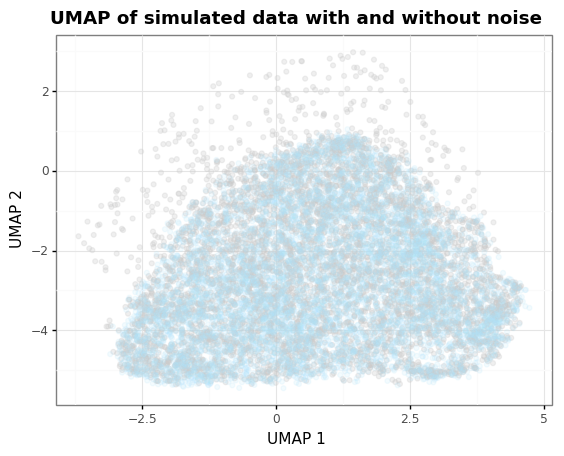

<ggplot: (-9223363249968999606)>


In [10]:
# Overlay original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'simulated'
simulated_data_UMAPencoded_df['dataset'] = 'noisy simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
g_input_sim = ggplot(combined_data_df[combined_data_df['dataset'] == 'simulated'], aes(x='1', y='2'))
g_input_sim += geom_point(color='#cccccc', 
                          alpha=0.3)
g_input_sim += labs(x = "UMAP 1", 
                    y = "UMAP 2", 
                    title = "UMAP of simulated data with and without noise")
g_input_sim += theme_bw()
g_input_sim += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')
)
g_input_sim += geom_point(combined_data_df[combined_data_df['dataset'] == 'noisy simulated'],
                          alpha=0.15, 
                          color='#b3e5fc')

print(g_input_sim)
ggsave(plot = g_input_sim, filename = umap_overlay_file, dpi=500)